In [1]:
from mica_text_coref.coref.movie_coref import data
from mica_text_coref.coref.movie_coref import evaluate

import yaml
import pandas as pd
import numpy as np
import os
import scipy.stats
import collections
import matplotlib.pyplot as plt
import json
import jsonlines
from scipy import optimize
import statistics
import tqdm
import statsmodels
import statsmodels.formula.api as smf

pd.set_option("display.min_rows", 50)
evaluator = evaluate.Evaluator()

Read the cross validation and baseline dataframes

In [2]:
df1 = pd.read_csv(os.path.join(os.getenv("DATA_DIR"),
                               "mica_text_coref/movie_coref/results/coreference/cross_val_1.csv"), index_col=None)
df2 = pd.read_csv(os.path.join(os.getenv("DATA_DIR"),
                               "mica_text_coref/movie_coref/results/coreference/cross_val_2.csv"), index_col=None)
df3 = pd.read_csv(os.path.join(os.getenv("DATA_DIR"),
                               "mica_text_coref/movie_coref/results/coreference/cross_val_4.csv"), index_col=None)
df4 = pd.read_csv(os.path.join(os.getenv("DATA_DIR"),
                               "mica_text_coref/movie_coref/results/coreference/cross_val_5.csv"), index_col=None)
df5 = pd.read_csv(os.path.join(os.getenv("DATA_DIR"),
                               "mica_text_coref/movie_coref/results/coreference/cross_val_6.csv"), index_col=None)
bl = pd.read_csv(os.path.join(os.getenv("DATA_DIR"),
                              "mica_text_coref/movie_coref/results/coreference/full_length.baseline.tsv"), sep="\t",
                              index_col=None)
fdf = pd.read_csv(os.path.join(os.getenv("DATA_DIR"),
                               "mica_text_coref/movie_coref/results/coreference/final.csv"), index_col=None)

print("df1")
for col, dtype in zip(df1.columns, df1.dtypes):
    print(f"\t{col} ({dtype})")
print()

print("df2")
for col, dtype in zip(df2.columns, df2.dtypes):
    print(f"\t{col} ({dtype})")
print()

print("df3")
for col, dtype in zip(df3.columns, df3.dtypes):
    print(f"\t{col} ({dtype})")
print()

print("df4")
for col, dtype in zip(df4.columns, df4.dtypes):
    print(f"\t{col} ({dtype})")
print()

print("df5")
for col, dtype in zip(df5.columns, df5.dtypes):
    print(f"\t{col} ({dtype})")
print()

print("bl")
for col, dtype in zip(bl.columns, bl.dtypes):
    print(f"\t{col} ({dtype})")
print()

print("fdf")
for col, dtype in zip(fdf.columns, fdf.dtypes):
    print(f"\t{col} ({dtype})")

df1
	preprocess (object)
	bert_lr (float64)
	model_lr (float64)
	warmup (float64)
	movie (object)
	dev_lea (float64)
	train_lea (float64)
	best_epoch (int64)
	dev_scores (object)
	train_scores (object)

df2
	weight_decay (float64)
	dropout (float64)
	movie (object)
	dev_lea (float64)
	best_epoch (int64)
	dev_scores (object)

df3
	dev_document_len (int64)
	dev_overlap_len (int64)
	movie (object)
	dev_lea (float64)
	best_epoch (int64)
	dev_scores (object)

df4
	dev_document_len (int64)
	repk (int64)
	movie (object)
	dev_lea (float64)
	best_epoch (int64)
	dev_scores (object)
	dev_gpu_memory (float64)

df5
	dev_document_len (int64)
	dev_overlap_len (int64)
	merge_strategy (object)
	load_bert (bool)
	freeze_bert (bool)
	add_cr_to_coarse (bool)
	filter_by_cr (bool)
	remove_singleton (bool)
	movie (object)
	dev_lea (float64)
	best_epoch (int64)

bl
	preprocess (object)
	genre (object)
	split_len (int64)
	overlap_len (int64)
	merge_strategy (object)
	merge_speakers (bool)
	entity (object)
	rem

Find the macro scores (averaged across movies)

In [3]:
print("macro average df1:")
macro_df1 = (df1.groupby(["preprocess", "bert_lr", "model_lr", "warmup"])
            .agg({"dev_lea": "mean", "best_epoch": "mean", "movie": "count"})
            .sort_values(by="dev_lea", ascending=False))
macro_df1 = macro_df1.loc[macro_df1["movie"] == 6]
print(macro_df1.shape)
display(macro_df1.head(10))
print()

print("macro average df2:")
macro_df2 = (df2.groupby(["weight_decay", "dropout"])
            .agg({"dev_lea": "mean", "best_epoch": "mean", "movie": "count"})
            .sort_values(by="dev_lea", ascending=False))
macro_df2 = macro_df2.loc[macro_df2["movie"] == 6]
print(macro_df2.shape)
display(macro_df2.head(10))
print()

print("macro average df3:")
macro_df3 = (df3.groupby(["dev_document_len", "dev_overlap_len"])
            .agg({"dev_lea": "mean", "best_epoch": "mean", "movie": "count"})
            .sort_values(by="dev_lea", ascending=False))
macro_df3 = macro_df3.loc[macro_df3["movie"] == 6]
print(macro_df3.shape)
display(macro_df3.head(10))
print()

print("macro average df4:")
macro_df4 = (df4.groupby(["dev_document_len", "repk"])
            .agg({"dev_lea": "mean", "best_epoch": "mean", "movie": "count", "dev_gpu_memory": "mean"})
            .sort_values(by="dev_lea", ascending=False))
macro_df4 = macro_df4.loc[macro_df4["movie"] == 6]
print(macro_df4.shape)
display(macro_df4.head(10))
print()

print("macro average df5:")
macro_df5 = (df5.groupby(["dev_document_len", "dev_overlap_len", "load_bert", "freeze_bert",
                          "add_cr_to_coarse", "filter_by_cr", "remove_singleton", "merge_strategy"])
            .agg({"dev_lea": "mean", "best_epoch": "mean", "movie": "count"})
            .sort_values(by="dev_lea", ascending=False))
macro_df5 = macro_df5.loc[macro_df5["movie"] == 6]
print(macro_df5.shape)
display(macro_df5.head(10))
print()

print("macro average bl:")
bl_ = bl.loc[(bl["movie"] != "all") & ~bl["remove_gold_singletons"] & ~bl["provide_gold_mentions"]
             & (bl["metric"] == "lea")]
macro_bl = (bl_.groupby(["preprocess", "genre", "split_len", "overlap_len", "merge_strategy", "merge_speakers",
                        "entity"])
            .agg({"F": "mean", "P": "mean", "R": "mean", "movie": "count"})
            .sort_values(by="F", ascending=False))
macro_bl = macro_bl.loc[(macro_bl["movie"] == 6)]
print(macro_bl.shape)
display(macro_bl.head(10))
print()

print("macro average fdf:")
macro_fdf = (fdf.groupby(["document_len", "overlap_len", "hierarchical", "repk"])
                .agg({"movie": "count", "max_gpu": ["max", "mean"], "best_epoch": "mean",
                      "muc_p": "mean", "muc_r": "mean", "muc_f1": "mean",
                      "bcub_p": "mean", "bcub_r": "mean", "bcub_f1": "mean",
                      "ceafe_p": "mean", "ceafe_r": "mean", "ceafe_f1": "mean",
                      "lea_p": "mean", "lea_r": "mean", "lea_f1": "mean",
                      "conll_f1": "mean"})
                .sort_values(by=("lea_f1", "mean"), ascending=False))
macro_fdf = macro_fdf[macro_fdf["movie"]["count"] == 6]
print(macro_fdf.shape)
display(macro_fdf.head(10))

macro average df1:
(108, 3)


dev_lea  best_epoch  movie
preprocess bert_lr model_lr warmup                              
regular    0.00002 0.0002    50.0   61.600000    6.833333      6
addsays    0.00002 0.0001   -1.0    61.592167    6.333333      6
           0.00001 0.0002   -1.0    61.572500    8.166667      6
regular    0.00002 0.0002    100.0  61.405833    8.166667      6
addsays    0.00002 0.0002    50.0   61.316833    5.666667      6
                   0.0001    0.0    61.287667    7.166667      6
regular    0.00005 0.0002    50.0   61.252167    7.666667      6
addsays    0.00002 0.0005   -1.0    61.202667    6.833333      6
           0.00005 0.0001    50.0   60.993833   11.500000      6
regular    0.00002 0.0005    0.0    60.984667    7.000000      6


macro average df2:
(40, 3)


dev_lea  best_epoch  movie
weight_decay dropout                              
0.0010       0.0      61.600000    6.833333      6
0.0100       0.0      61.085833   11.000000      6
1.0000       0.0      61.080167    8.333333      6
0.1000       0.0      60.119500    6.666667      6
0.0001       0.0      59.836667    5.666667      6
0.0000       0.0      59.836667    5.666667      6
10.0000      0.0      59.632000    7.166667      6
             0.2      58.728167    8.000000      6
0.1000       0.2      57.957000    3.833333      6
1.0000       0.2      57.753333    5.166667      6


macro average df3:
(44, 3)


dev_lea  best_epoch  movie
dev_document_len dev_overlap_len                              
10240            4096             79.530167    7.666667      6
20480            4096             79.503500    8.333333      6
                 5120             79.380667    8.000000      6
                 3072             79.197833    7.500000      6
10240            3072             78.889333    7.666667      6
20480            2048             78.874833    8.666667      6
8192             3072             77.310667    6.666667      6
20480            1024             77.163167    9.333333      6
10240            2048             76.955833   10.500000      6
8192             2048             76.658000    8.166667      6


macro average df4:
(25, 4)


dev_lea  best_epoch  movie  dev_gpu_memory
dev_document_len repk                                              
8192             4     78.637500   11.166667      6       15.931667
20480            3     77.426167    9.833333      6       14.310000
                 4     77.321500   11.000000      6       14.620000
10240            3     76.504500   11.666667      6       11.088333
20480            2     76.242833   10.333333      6       14.260000
5120             4     76.150333    8.833333      6       17.981667
20480            1     76.098000   11.500000      6       14.260000
8192             2     75.237000   10.166667      6        9.856667
10240            4     73.882167    7.166667      6       15.296667
8192             3     72.879167    8.833333      6       13.080000


macro average df5:
(55, 3)


dev_lea  \
dev_document_len dev_overlap_len load_bert freeze_bert add_cr_to_coarse filter_by_cr remove_singleton merge_strategy              
8192             3072            True      False       True             False        True             none            76.581667   
                                                                        True         True             avg             76.556500   
                                                                        False        True             avg             76.387500   
                                                                                                      max             75.843500   
                                                       False            False        True             avg             75.785667   
                                                       True             False        True             pre             75.747667   
                                                                                                      post            75.733333   
                 2048            True      False       False            False        True             avg             75.703167   
                                                       True             False        True             post            75.612833   
                 3072            True      False       True             False        True             min             75.568167   

                                                                                                                      best_epoch  \
dev_document_len dev_overlap_len load_bert freeze_bert add_cr_to_coarse filter_by_cr remove_singleton merge_strategy               
8192             3072            True      False       True             False        True             none              9.000000   
                                                                        True         True             avg               8.833333   
                                                                        False        True             avg               8.833333   
                                                                                                      max               6.833333   
                                                       False            False        True             avg               8.166667   
                                                       True             False        True             pre               7.000000   
                                                                                                      post              7.000000   
                 2048            True      False       False            False        True             avg               7.666667   
                                                       True             False        True             post              7.833333   
                 3072            True      False       True             False        True             min               7.333333   

                                                                                                                      movie  
dev_document_len dev_overlap_len load_bert freeze_bert add_cr_to_coarse filter_by_cr remove_singleton merge_strategy         
8192             3072            True      False       True             False        True             none                6  
                                                                        True         True             avg                 6  
                                                                        False        True             avg                 6  
                                                                                                      max                 6  
                                                       False            False        True             avg                 6  
                                                       True             False   


macro average bl:
(9072, 4)


F  \
preprocess genre split_len overlap_len merge_strategy merge_speakers entity               
addsays    wb    3072      512         avg            True           speaker  59.432041   
                                       min            True           speaker  59.413063   
                                       post           True           speaker  59.381315   
                 5120      128         none           True           speaker  59.241314   
           tc    3072      512         avg            True           speaker  59.165600   
           mz    5120      128         none           True           speaker  59.056600   
           tc    3072      512         post           True           speaker  59.033369   
           wb    5120      128         max            True           speaker  58.976455   
                 3072      512         max            True           speaker  58.968410   
                 5120      128         avg            True           speaker  58.966080   

                                                                                      P  \
preprocess genre split_len overlap_len merge_strategy merge_speakers entity               
addsays    wb    3072      512         avg            True           speaker  63.533619   
                                       min            True           speaker  63.328625   
                                       post           True           speaker  63.409019   
                 5120      128         none           True           speaker  63.738806   
           tc    3072      512         avg            True           speaker  63.823944   
           mz    5120      128         none           True           speaker  63.873560   
           tc    3072      512         post           True           speaker  63.716996   
           wb    5120      128         max            True           speaker  63.838738   
                 3072      512         max            True           speaker  63.445235   
                 5120      128         avg            True           speaker  63.812845   

                                                                                      R  \
preprocess genre split_len overlap_len merge_strategy merge_speakers entity               
addsays    wb    3072      512         avg            True           speaker  57.525410   
                                       min            True           speaker  57.745973   
                                       post           True           speaker  57.631609   
                 5120      128         none           True           speaker  57.320530   
           tc    3072      512         avg            True           speaker  56.881757   
           mz    5120      128         none           True           speaker  56.811269   
           tc    3072      512         post           True           speaker  56.859903   
           wb    5120      128         max            True           speaker  56.683490   
                 3072      512         max            True           speaker  56.734903   
                 5120      128         avg            True           speaker  56.679984   

                                                                              movie  
preprocess genre split_len overlap_len merge_strategy merge_speakers entity          
addsays    wb    3072      512         avg            True           speaker      6  
                                       min            True           speaker      6  
                                       post           True           speaker      6  
                 5120      128         none           True           speaker      6  
           tc    3072      512         avg            True           speaker      6  
           mz    5120      128         none           True           speaker      6  
           tc    3072      512         post           True           speaker      6  
           wb    5120      128   


macro average fdf:
(44, 17)


movie max_gpu             \
                                           count     max       mean   
document_len overlap_len hierarchical repk                            
10240        2048        False        3        6    9.19   9.166667   
8192         2048        False        3        6    8.55   8.536667   
10240        512         True         3        6   23.93  13.313333   
                                      4        6   36.32  17.690000   
8192         512         True         4        6   41.73  19.543333   
10240        1024        False        3        6    9.18   9.166667   
8192         512         True         3        6   27.01  14.268333   
                                      2        6   16.36  10.573333   
4096         512         True         3        6   35.35  17.421667   
10240        512         True         2        6   14.97  10.330000   

                                           best_epoch      muc_p      muc_r  \
                                                 mean       mean       mean   
document_len overlap_len hierarchical repk                                    
10240        2048        False        3      8.500000  93.809167  92.926500   
8192         2048        False        3      9.166667  94.076333  92.469333   
10240        512         True         3      7.333333  93.999833  92.190167   
                                      4      7.500000  93.943833  92.165833   
8192         512         True         4      7.833333  94.110000  91.631500   
10240        1024        False        3      7.833333  93.890167  92.752333   
8192         512         True         3      7.833333  94.279333  91.711833   
                                      2      6.833333  94.195000  91.987500   
4096         512         True         3      7.500000  94.269833  92.080167   
10240        512         True         2      6.166667  94.021833  92.120000   

                                               muc_f1     bcub_p     bcub_r  \
                                                 mean       mean       mean   
document_len overlap_len hierarchical repk                                    
10240        2048        False        3     93.358667  81.275833  74.583667   
8192         2048        False        3     93.255667  81.536167  73.323000   
10240        512         True         3     93.062167  75.707500  77.979667   
                                      4     93.022000  75.562667  77.711000   
8192         512         True         4     92.830833  76.860167  76.132333   
10240        1024        False        3     93.310833  80.890667  71.951167   
8192         512         True         3     92.953833  75.465333  76.701333   
                                      2     93.054333  73.312667  78.155833   
4096         512         True         3     93.138333  73.111167  78.084000   
10240        512         True         2     93.037000  73.243833  77.818667   

                                              bcub_f1    ceafe_p    ceafe_r  \
                                                 mean       mean       mean   
document_len overlap_len hierarchical repk                                    
10240        2048        False        3     77.753000  37.151833  63.794833   
8192         2048        False        3     76.915333  33.619500  61.611167   
10240        512         True         3     76.442500  36.089833  62.949500   
                                      4     76.254667  34.838500  61.820167   
8192         512         True         4     76.150000  33.345167  61.883167   
10240        1024        False        3     76.123667  34.645000  62.526333   
8192         512         True         3     75.812167  36.955500  59.799833   
                                      2     75.396000  38.741167  58.479167   
4096         512         True         3     75.170667  36.715833  58.214833   
10240        512         True         2     75.016667  34.552500  59.524333   

                                   

Plot dev lea for different document document lens and overlap lens

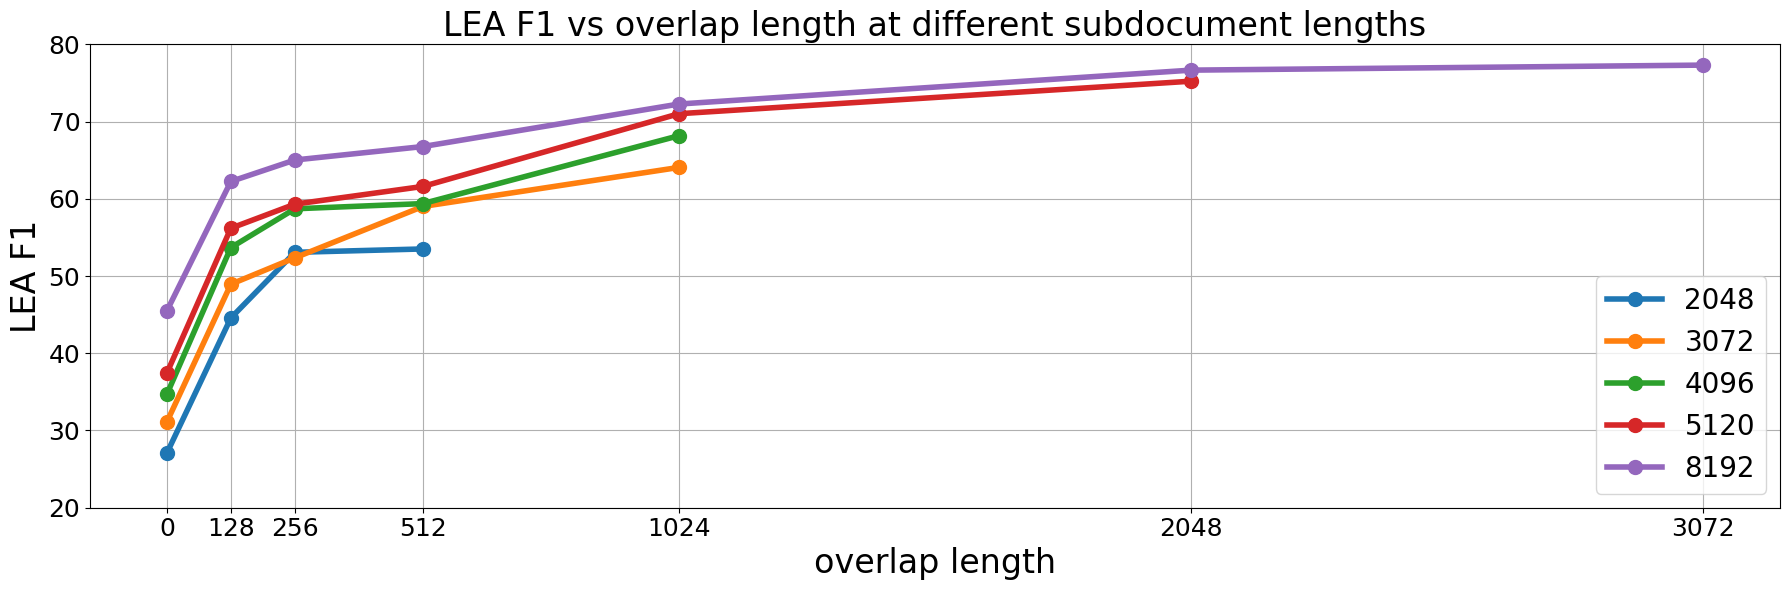

In [23]:
df_ = macro_df3.reset_index()
plt.figure(figsize=(18, 6))
for document_len, df__ in df_.groupby("dev_document_len"):
    if document_len <= 8192:
        df__ = df__.sort_values(by="dev_overlap_len", ascending=True)
        overlap_lens = df__["dev_overlap_len"].tolist()
        scores = df__["dev_lea"].tolist()
        plt.plot(overlap_lens, scores, label=str(document_len), lw=4, marker=".", markersize=20)
plt.xlabel("overlap length", fontsize=24)
plt.ylabel("LEA F1", fontsize=24)
plt.xticks(ticks=[0, 128, 256, 512, 1024, 2048, 3072], fontsize=18)
plt.yticks(ticks=[20, 30, 40, 50, 60, 70, 80], fontsize=18)
plt.title("LEA F1 vs overlap length at different subdocument lengths", fontsize=24)
plt.legend(fontsize=20)
plt.tight_layout()
plt.grid(visible=True, which="both")
plt.show()

In [5]:
df3.loc[(df3["dev_document_len"] == 20480) & (df3["dev_overlap_len"] == 1024)].sort_values(by="movie")

,dev_document_len,dev_overlap_len,movie,dev_lea,best_epoch,dev_scores
111,20480,1024,avengers_endgame,57.756,8,"[51.584, 53.3672, 51.4475, 54.8695, 53.0705, 5..."
71,20480,1024,dead_poets_society,80.624,6,"[55.0021, 72.1688, 70.1121, 64.728, 75.5696, 8..."
13,20480,1024,john_wick,83.802,10,"[68.1938, 72.909, 79.8273, 81.4043, 81.7847, 7..."
185,20480,1024,prestige,75.325,3,"[70.6964, 72.4374, 75.3249, 75.2531, 67.9563, ..."
64,20480,1024,quiet_place,85.872,14,"[65.7963, 68.6753, 64.54, 76.9486, 77.7601, 74..."
172,20480,1024,zootopia,79.600,15,"[70.9066, 73.8026, 73.9908, 74.7188, 77.4368, ..."


In [6]:
df3.loc[(df3["dev_document_len"] == 5120) & (df3["dev_overlap_len"] == 2048)].sort_values(by="movie")

,dev_document_len,dev_overlap_len,movie,dev_lea,best_epoch,dev_scores
240,5120,2048,avengers_endgame,61.099,6,"[47.0113, 49.8996, 49.2513, 51.3355, 53.4044, ..."
231,5120,2048,dead_poets_society,71.839,6,"[45.6969, 60.2393, 66.2537, 64.5423, 66.3541, ..."
226,5120,2048,john_wick,82.219,15,"[69.2355, 73.3531, 78.0478, 79.9631, 78.9058, ..."
244,5120,2048,prestige,74.583,3,"[60.7617, 63.0549, 74.5835, 74.0211, 69.1432, ..."
208,5120,2048,quiet_place,85.959,10,"[68.4333, 72.0559, 67.3808, 80.0417, 77.465, 7..."
242,5120,2048,zootopia,75.665,20,"[69.8173, 70.1177, 69.4761, 70.4887, 74.232, 7..."


In [8]:
macro_df3.sort_index()

dev_lea  best_epoch  movie
dev_document_len dev_overlap_len                              
2048             0                27.060167    8.333333      6
                 128              44.569333    9.166667      6
                 256              53.068000    9.666667      6
                 512              53.505833    9.166667      6
3072             0                31.091667    9.833333      6
                 128              48.938833   10.333333      6
                 256              52.359000    9.000000      6
                 512              59.007333    8.000000      6
                 1024             64.063500    6.333333      6
4096             0                34.681167    9.000000      6
                 128              53.680500    5.833333      6
                 256              58.706500   11.166667      6
                 512              59.379000    6.666667      6
                 1024             68.168833    8.666667      6
5120             0                37.424833    8.000000      6
                 128              56.189000    8.166667      6
                 256              59.306500    8.500000      6
                 512              61.600000    6.833333      6
                 1024             71.015667    8.666667      6
                 2048             75.227333   10.000000      6
8192             0                45.476500    8.166667      6
                 128              62.244833    8.333333      6
                 256              65.024500    6.833333      6
                 512              66.765167    7.500000      6
                 1024             72.270167    8.000000      6
                 2048             76.658000    8.166667      6
                 3072             77.310667    6.666667      6
10240            0                49.342167    8.500000      6
                 128              68.863500    9.500000      6
                 256              69.325500    8.500000      6
                 512              71.674333    7.833333      6
                 1024             75.509333    6.166667      6
                 2048             76.955833   10.500000      6
                 3072             78.889333    7.666667      6
                 4096             79.530167    7.666667      6
20480            0                64.084167    9.666667      6
                 128              71.217000    9.333333      6
                 256              75.427500    7.333333      6
                 512              76.531000    8.833333      6
                 1024             77.163167    9.333333      6
                 2048             78.874833    8.666667      6
                 3072             79.197833    7.500000      6
                 4096             79.503500    8.333333      6
                 5120             79.380667    8.000000      6

Plot dev lea for different document lengths and repk in the hierarchical model

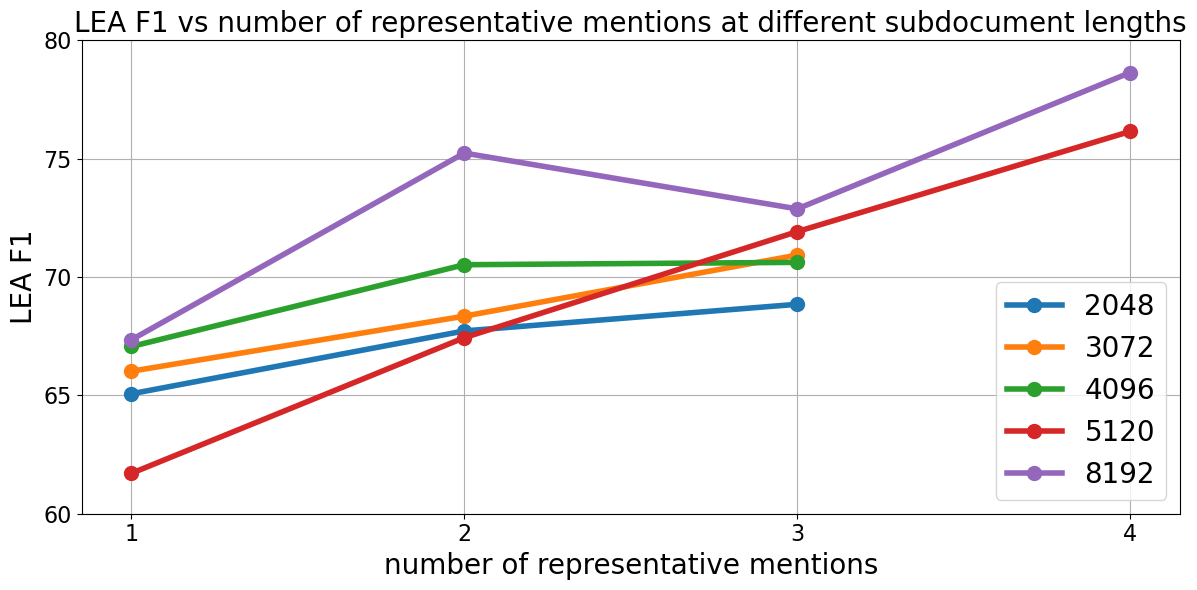

In [30]:
df_ = macro_df4.reset_index()
plt.figure(figsize=(12, 6))
for document_len, df__ in df_.groupby("dev_document_len"):
    if document_len <= 8192:
        df__ = df__.sort_values(by="repk", ascending=True)
        repks = df__["repk"].tolist()
        scores = df__["dev_lea"].tolist()
        plt.plot(repks, scores, label=str(document_len), lw=4, marker=".", markersize=20)
plt.xlabel("number of representative mentions", fontsize=20)
plt.ylabel("LEA F1", fontsize=20)
plt.xticks(ticks=[1, 2, 3, 4], fontsize=16)
plt.yticks(ticks=[60, 65, 70, 75, 80], fontsize=16)
plt.title("LEA F1 vs number of representative mentions at different subdocument lengths", fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.grid(visible=True, which="both")
plt.show()

In [7]:
macro_df4.sort_index()

dev_lea  best_epoch  movie  dev_gpu_memory
dev_document_len repk                                              
2048             1     65.067333    9.333333      6        8.860000
                 2     67.722833    8.000000      6       12.940000
                 3     68.848333    7.833333      6       19.486667
3072             1     66.021500    7.666667      6        8.533333
                 2     68.347333    9.000000      6       11.503333
                 3     70.927333    8.666667      6       16.506667
4096             1     67.065333    9.166667      6        8.381667
                 2     70.519833   10.500000      6       10.873333
                 3     70.619833    7.500000      6       15.518333
5120             1     61.708500    6.166667      6        8.405000
                 2     67.438500    8.000000      6       10.375000
                 3     71.918167    7.666667      6       13.848333
                 4     76.150333    8.833333      6       17.981667
8192             1     67.349833    5.166667      6        8.428333
                 2     75.237000   10.166667      6        9.856667
                 3     72.879167    8.833333      6       13.080000
                 4     78.637500   11.166667      6       15.931667
10240            1     68.568333    8.833333      6        9.133333
                 2     71.526000    8.333333      6        9.670000
                 3     76.504500   11.666667      6       11.088333
                 4     73.882167    7.166667      6       15.296667
20480            1     76.098000   11.500000      6       14.260000
                 2     76.242833   10.333333      6       14.260000
                 3     77.426167    9.833333      6       14.310000
                 4     77.321500   11.000000      6       14.620000

Variation for less important hyperparam

In [6]:
df_ = macro_df5.reset_index()
df_[(df_["dev_document_len"] == 5120) & (df_["dev_overlap_len"] == 512)]

,dev_document_len,dev_overlap_len,load_bert,freeze_bert,add_cr_to_coarse,filter_by_cr,remove_singleton,merge_strategy,dev_lea,best_epoch,movie
40,5120,512,True,False,True,True,True,avg,60.697167,10.166667,6
41,5120,512,True,False,True,False,True,avg,60.682000,10.166667,6
42,5120,512,True,False,True,False,True,max,60.500333,10.333333,6
43,5120,512,True,False,True,False,True,pre,60.295333,9.166667,6
44,5120,512,True,False,False,False,True,avg,60.170500,7.000000,6
45,5120,512,True,False,True,False,True,none,60.016500,7.166667,6
46,5120,512,True,False,True,False,True,post,59.878000,6.666667,6
47,5120,512,True,False,True,False,True,min,59.871833,6.666667,6
48,5120,512,False,False,True,False,True,avg,54.886167,18.333333,6
49,5120,512,True,True,True,False,True,avg,54.464500,11.333333,6


Baseline vs Model

In [4]:
macro_fdf.loc[(5120, slice(None), False, slice(None))]

movie max_gpu           best_epoch      muc_p      muc_r  \
                 count     max      mean       mean       mean       mean   
overlap_len repk                                                            
2048        3        6    8.07  7.961667   8.333333  93.864000  92.830333   
1024        3        6    8.06  7.955000   9.500000  93.830167  92.352167   
512         3        6    8.01  7.943333  11.333333  93.778667  91.999167   
256         3        6    8.06  7.948333  12.500000  93.743167  91.906667   
128         3        6    8.01  7.940000   7.500000  93.469167  91.758833   

                     muc_f1     bcub_p     bcub_r    bcub_f1    ceafe_p  \
                       mean       mean       mean       mean       mean   
overlap_len repk                                                          
2048        3     93.337167  81.282833  69.045500  74.497500  34.689667   
1024        3     93.078000  81.893667  63.652500  71.154167  29.718833   
512         3     92.868333  81.929333  51.205167  62.789333  26.134667   
256         3     92.807000  79.406167  49.011667  60.473333  25.333333   
128         3     92.597833  79.632667  46.060833  57.756333  23.906167   

                    ceafe_r   ceafe_f1      lea_p      lea_r     lea_f1  \
                       mean       mean       mean       mean       mean   
overlap_len repk                                                          
2048        3     62.944667  43.324167  80.964167  68.691167  74.156167   
1024        3     61.492333  38.735833  81.549833  63.276167  70.776667   
512         3     60.218833  35.342667  81.561167  50.786333  62.362167   
256         3     57.769333  34.157167  79.055833  48.612833  60.067333   
128         3     59.359333  32.950167  79.235667  45.627167  57.299000   

                   conll_f1  
                       mean  
overlap_len repk             
2048        3     70.386278  
1024        3     67.656000  
512         3     63.666778  
256         3     62.479167  
128         3     61.101444

In [4]:
macro_bl.reset_index()["split_len"].unique()

array([3072, 5120, 2048, 4096])

In [12]:
macro_bl.loc[("addsays", "wb", 5120, 512, "avg", True, "speaker")].round(1)

F        57.3
P        63.2
R        54.7
movie     6.0
Name: (addsays, wb, 5120, 512, avg, True, speaker), dtype: float64

In [18]:
fdf_ = fdf[(fdf["document_len"] == 5120) & (fdf["overlap_len"] == 2048) & ~fdf["hierarchical"]]

In [20]:
data = []
for file in fdf_["file"]:
    dir_ = os.path.join(os.getenv("DATA_DIR"), "mica_text_coref/movie_coref/results/coreference/final_Jan12", file)
    data_file = os.path.join(dir_, "test_5120_2048_avg.jsonlines")
    with jsonlines.open(data_file, "r") as reader:
        for obj in reader:
            data.append(obj)
print(len(data))
print(data[0].keys())

6
dict_keys(['movie', 'rater', 'token', 'parse', 'pos', 'ner', 'is_pronoun', 'is_punctuation', 'speaker', 'gold', 'pred_word', 'pred_span', 'pred_head'])


In [26]:
f1s = []
for data_ in data:
    movie = data_["movie"]
    gold_clusters = [set([tuple(mention[:2]) for mention in cluster]) for cluster in data_["gold"]]
    pred_clusters = [set([tuple(mention) for mention in cluster]) for cluster in data_["pred_span"]]
    gold_singletons = [cluster[0][0] for cluster in data_["gold"] if len(cluster) == 1]
    art_pred_singletons = [set([(g, g)]) for g in gold_singletons]
    n_gold_singletons = sum([len(cluster) == 1 for cluster in gold_clusters])
    n_pred_singletons = sum([len(cluster) == 1 for cluster in pred_clusters])
    # rN, rD, pN, pD = evaluator._ceafe(gold_clusters, pred_clusters)
    rN, rD, pN, pD = evaluator._muc(gold_clusters, pred_clusters + art_pred_singletons)
    recall = rN/rD
    precision = pN/pD
    f1 = 2 * precision * recall / (precision + recall)
    f1s.append(100*f1)
    print(f"movie={movie}, f1={100*f1:.1f}, gS={n_gold_singletons}, pS={n_pred_singletons}")
print(f"average f1={np.mean(f1s):.1f}")

movie=quiet_place, f1=95.8, gS=0, pS=0
movie=zootopia, f1=93.1, gS=35, pS=0
movie=avengers_endgame, f1=91.5, gS=2, pS=0
movie=dead_poets_society, f1=93.0, gS=4, pS=0
movie=prestige, f1=93.2, gS=2, pS=0
movie=john_wick, f1=93.5, gS=0, pS=0
average f1=93.3


In [48]:
for data_ in data:
    movie = data_["movie"]
    pred_head = np.array(data_["pred_head"])
    gold_singletons = [cluster[0][0] for cluster in data_["gold"] if len(cluster) == 1]
    print(pred_head[gold_singletons])

[0 0]
[1 1 1 1]
[]
[0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0]
[]
[1 0]


In [3]:
bl2 = pd.read_csv(os.path.join(os.getenv("DATA_DIR"), 
                                "mica_text_coref/movie_coref/results/coreference/baselines/"
                                "preprocess_addsays.genre_wb.split_5120.overlap_512.conll.baseline.tsv"),
                  index_col=None, sep="\t")
bl2

,preprocess,genre,split_len,overlap_len,merge_strategy,merge_speakers,entity,remove_gold_singletons,provide_gold_mentions,movie,metric,P,R,F
0,addsays,wb,5120,512,avg,True,speaker,False,False,avengers_endgame,muc,88.600805,80.016149,84.089945
1,addsays,wb,5120,512,avg,True,speaker,False,False,avengers_endgame,bcub,46.369008,62.233614,53.142565
2,addsays,wb,5120,512,avg,True,speaker,False,False,avengers_endgame,ceafe,57.639413,36.532022,44.720234
3,addsays,wb,5120,512,avg,True,speaker,False,False,dead_poets_society,muc,89.153723,89.321170,89.237368
4,addsays,wb,5120,512,avg,True,speaker,False,False,dead_poets_society,bcub,45.616822,77.705270,57.486334
5,addsays,wb,5120,512,avg,True,speaker,False,False,dead_poets_society,ceafe,72.245747,42.497498,53.515368
6,addsays,wb,5120,512,avg,True,speaker,False,False,john_wick,muc,90.817223,81.186174,85.732061
7,addsays,wb,5120,512,avg,True,speaker,False,False,john_wick,bcub,78.686164,69.601562,73.865586
8,addsays,wb,5120,512,avg,True,speaker,False,False,john_wick,ceafe,68.149368,62.136188,65.004013
9,addsays,wb,5120,512,avg,True,speaker,False,False,prestige,muc,88.344343,81.198590,84.620880


In [14]:
display(bl2[bl2["movie"] != "micro"].groupby("metric").agg({"P": "mean", "R": "mean", "F": "mean", "movie": "count"}).round(1))
display(bl2[bl2["movie"] != "micro"].groupby("metric").agg({"P": "mean", "R": "mean", "F": "mean", "movie": "count"}).mean().round(1))

,P,R,F,movie
metric,,,,
bcub,54.8,63.3,57.5,6
ceafe,61.5,40.9,47.9,6
muc,89.3,79.2,83.7,6


P        68.5
R        61.1
F        63.1
movie     6.0
dtype: float64

Ablation

In [29]:
macro_fdf.loc[(slice(None), slice(None), False, slice(None)), [("lea_f1", "mean"), ("max_gpu", "max"), ("max_gpu", "mean")]].sort_index().round(1)

lea_f1 max_gpu     
                                             mean     max mean
document_len overlap_len hierarchical repk                    
2048         128         False        3      44.3     7.6  7.6
             256         False        3      51.5     7.6  7.6
             512         False        3      53.1     7.6  7.6
3072         256         False        3      52.4     7.8  7.7
             512         False        3      59.2     7.8  7.7
             1024        False        3      63.8     7.8  7.7
4096         128         False        3      53.5     7.9  7.8
             256         False        3      58.6     7.9  7.8
             512         False        3      58.4     7.9  7.8
             1024        False        3      68.7     7.9  7.8
5120         128         False        3      57.3     8.0  7.9
             256         False        3      60.1     8.1  7.9
             512         False        3      62.4     8.0  7.9
             1024        False        3      70.8     8.1  8.0
             2048        False        3      74.2     8.1  8.0
8192         128         False        3      61.8     8.6  8.5
             256         False        3      64.6     8.6  8.5
             512         False        3      67.0     8.5  8.5
             1024        False        3      72.9     8.6  8.5
             2048        False        3      76.6     8.6  8.5
10240        128         False        3      68.4     9.2  9.2
             256         False        3      70.2     9.2  9.2
             512         False        3      70.8     9.2  9.2
             1024        False        3      75.8     9.2  9.2
             2048        False        3      77.4     9.2  9.2

In [31]:
for index, row in (macro_fdf.loc[(slice(None), slice(None), False, slice(None)), 
                                [("lea_f1", "mean"), ("max_gpu", "max"), ("max_gpu", "mean")]]
                            .sort_index().iterrows()):
    subdoc, overlap = index[:2]
    lea, mem_max, mem_mean = row.values
    if subdoc in [2048, 3072, 4096, 5120, 8192] and overlap in [256, 512, 1024, 2048]:
        print(f"{subdoc:4d} {overlap:4d} {lea:.1f} {mem_mean:4.1f}")

2048  256 51.5  7.6
2048  512 53.1  7.6
3072  256 52.4  7.7
3072  512 59.2  7.7
3072 1024 63.8  7.7
4096  256 58.6  7.8
4096  512 58.4  7.8
4096 1024 68.7  7.8
5120  256 60.1  7.9
5120  512 62.4  7.9
5120 1024 70.8  8.0
5120 2048 74.2  8.0
8192  256 64.6  8.5
8192  512 67.0  8.5
8192 1024 72.9  8.5
8192 2048 76.6  8.5


In [21]:
macro_fdf.loc[(slice(None), slice(None), True, slice(None)), [("lea_f1", "mean"), ("max_gpu", "max"), ("max_gpu", "mean")]].sort_index().round(1)

lea_f1 max_gpu      
                                             mean     max  mean
document_len overlap_len hierarchical repk                     
2048         512         True         1      61.7    12.0   9.2
                                      2      67.5    24.6  14.0
3072         512         True         1      63.6    11.2   8.8
                                      2      72.1    21.5  12.6
                                      3      73.5    38.5  18.8
4096         512         True         1      69.8    10.8   8.6
                                      2      73.0    20.1  12.0
                                      3      74.9    35.4  17.4
5120         512         True         1      72.9    10.2   8.5
                                      2      72.3    17.9  11.3
                                      3      73.5    30.5  15.8
8192         512         True         1      72.9     9.8   8.7
                                      2      75.1    16.4  10.6
                                      3      75.6    27.0  14.3
                                      4      75.9    41.7  19.5
10240        512         True         1      73.7     9.4   9.2
                                      2      74.7    15.0  10.3
                                      3      76.2    23.9  13.3
                                      4      76.0    36.3  17.7

In [32]:
for index, row in (macro_fdf.loc[(slice(None), slice(None), True, slice(None)), 
                                [("lea_f1", "mean"), ("max_gpu", "max"), ("max_gpu", "mean")]].sort_index().iterrows()):
    subdoc, _, _, repk = index
    lea, mem_max, mem_mean = row.values
    if subdoc in [2048, 3072, 4096, 5120, 8192]:
        print(f"{subdoc:4d} {repk:4d} {lea:.1f} {mem_mean:4.1f}")

2048    1 61.7  9.2
2048    2 67.5 14.0
3072    1 63.6  8.8
3072    2 72.1 12.6
3072    3 73.5 18.8
4096    1 69.8  8.6
4096    2 73.0 12.0
4096    3 74.9 17.4
5120    1 72.9  8.5
5120    2 72.3 11.3
5120    3 73.5 15.8
8192    1 72.9  8.7
8192    2 75.1 10.6
8192    3 75.6 14.3
8192    4 75.9 19.5


Ensemble

In [9]:
display(macro_fdf.loc[(5120, 2048, False, slice(None))].round(1))
display(macro_fdf.loc[(5120, slice(None), True, 3)].round(1))

movie max_gpu      best_epoch muc_p muc_r muc_f1 bcub_p bcub_r bcub_f1  \
     count     max mean       mean  mean  mean   mean   mean   mean    mean   
repk                                                                          
3        6     8.1  8.0        8.3  93.9  92.8   93.3   81.3   69.0    74.5   

     ceafe_p ceafe_r ceafe_f1 lea_p lea_r lea_f1 conll_f1  
        mean    mean     mean  mean  mean   mean     mean  
repk                                                       
3       34.7    62.9     43.3  81.0  68.7   74.2     70.4

movie max_gpu       best_epoch muc_p muc_r muc_f1 bcub_p bcub_r  \
            count     max  mean       mean  mean  mean   mean   mean   mean   
overlap_len                                                                   
512             6    30.5  15.8        7.8  94.2  92.4   93.2   70.6   78.8   

            bcub_f1 ceafe_p ceafe_r ceafe_f1 lea_p lea_r lea_f1 conll_f1  
               mean    mean    mean     mean  mean  mean   mean     mean  
overlap_len                                                               
512            73.8    39.5    60.4     46.2  70.3  78.6   73.5     71.1

In [5]:
fusion_df = fdf[(fdf["document_len"] == 5120) & (fdf["overlap_len"] == 2048) & ~fdf["hierarchical"]].sort_values("movie")
hierarch_df = fdf[(fdf["document_len"] == 5120) & (fdf["repk"] == 3) & fdf["hierarchical"]].sort_values("movie")
display(fusion_df)
display(hierarch_df)

,document_len,overlap_len,hierarchical,repk,movie,file,muc_p,muc_r,muc_f1,bcub_p,...,bcub_f1,ceafe_p,ceafe_r,ceafe_f1,conll_f1,lea_p,lea_r,lea_f1,max_gpu,best_epoch
109,5120,2048,False,3,avengers_endgame,Jan12_02:42:47PM_avengers_endgame_excerpts_7831,92.923,90.109,91.494,63.965,...,54.512,24.246,57.370,34.086,60.030667,63.436,46.968,53.973,8.07,6
134,5120,2048,False,3,dead_poets_society,Jan12_06:04:04PM_dead_poets_society_excerpts_1...,92.145,93.802,92.966,82.920,...,72.826,27.547,61.035,37.961,67.917667,82.571,64.554,72.459,7.90,6
219,5120,2048,False,3,john_wick,Jan12_09:59:52PM_john_wick_excerpts_17621,94.899,92.066,93.461,88.874,...,82.217,44.930,76.645,56.651,77.443000,88.613,76.237,81.961,7.90,15
136,5120,2048,False,3,prestige,Jan13_01:20:26AM_prestige_excerpts_21837,94.181,92.244,93.203,84.608,...,74.386,18.286,61.850,28.227,65.272000,84.362,66.138,74.147,7.98,4
59,5120,2048,False,3,quiet_place,Jan13_04:45:42AM_quiet_place_excerpts_25565,95.987,95.607,95.797,87.730,...,86.284,46.419,77.365,58.024,80.035000,87.699,84.825,86.238,7.97,9
98,5120,2048,False,3,zootopia,Jan13_09:11:23AM_zootopia_excerpts_30169,93.049,93.154,93.102,79.600,...,76.760,46.710,43.403,44.996,71.619333,79.104,73.425,76.159,7.95,10


,document_len,overlap_len,hierarchical,repk,movie,file,muc_p,muc_r,muc_f1,bcub_p,...,bcub_f1,ceafe_p,ceafe_r,ceafe_f1,conll_f1,lea_p,lea_r,lea_f1,max_gpu,best_epoch
118,5120,512,True,3,avengers_endgame,Jan12_01:07:45PM_avengers_endgame_excerpts_hi_...,94.261,86.859,90.409,45.442,...,52.835,18.736,49.082,27.119,56.787667,45.046,62.684,52.421,30.49,2
164,5120,512,True,3,dead_poets_society,Jan12_02:41:30PM_dead_poets_society_excerpts_h...,92.213,94.365,93.277,49.718,...,62.051,32.781,55.920,41.332,65.553333,49.414,82.268,61.742,13.61,6
114,5120,512,True,3,john_wick,Jan12_05:44:01PM_john_wick_excerpts_hi_17959,94.315,92.537,93.418,84.442,...,84.062,47.617,70.025,56.687,78.055667,84.119,83.521,83.819,9.73,9
127,5120,512,True,3,prestige,Jan12_08:59:34PM_prestige_excerpts_hi_21459,94.546,92.009,93.261,80.972,...,80.050,31.934,72.321,44.305,72.538667,80.775,79.001,79.878,15.66,10
16,5120,512,True,3,quiet_place,Jan12_11:28:14PM_quiet_place_excerpts_hi_24286,95.845,95.535,95.690,83.837,...,84.320,49.682,71.762,58.715,79.575000,83.782,84.760,84.268,11.13,9
272,5120,512,True,3,zootopia,Jan13_02:51:05AM_zootopia_excerpts_hi_27986,93.826,92.957,93.390,79.030,...,79.328,56.118,43.206,48.823,73.847000,78.643,79.081,78.861,14.16,11


In [38]:
for movie in fusion_df["movie"].sort_values():
    fusion_filename = fusion_df.loc[fusion_df["movie"] == movie, "file"].item()
    fusion_data_file = os.path.join(os.getenv("DATA_DIR"), 
                                    "mica_text_coref/movie_coref/results/coreference/final_Jan12", 
                                    fusion_filename, "test_5120_2048_avg.jsonlines")
    hierarch_filename = hierarch_df.loc[hierarch_df["movie"] == movie, "file"].item()
    hierarch_data_file = os.path.join(os.getenv("DATA_DIR"), 
                                      "mica_text_coref/movie_coref/results/coreference/final_Jan12", 
                                      hierarch_filename, "test_5120.jsonlines")
    with open(fusion_data_file) as reader:
        fusion_data = json.load(reader)
    with open(hierarch_data_file) as reader:
        hierarch_data = json.load(reader)
    gold_clusters = [set([tuple(mention[:2]) for mention in cluster]) for cluster in hierarch_data["gold"]]
    fusion_clusters = [set([tuple(mention) for mention in cluster]) for cluster in fusion_data["pred_span"]]
    hierarch_clusters = [set([tuple(mention) for mention in cluster]) for cluster in hierarch_data["pred_span"]]
    fusion_rn, fusion_rd, fusion_pn, fusion_pd = evaluator._lea(gold_clusters, fusion_clusters)
    hierarch_rn, hierarch_rd, hierarch_pn, hierarch_pd = evaluator._lea(gold_clusters, hierarch_clusters)
    fusion_r, fusion_p = fusion_rn/fusion_rd, fusion_pn/fusion_pd
    hierarch_r, hierarch_p = hierarch_rn/hierarch_rd, hierarch_pn/hierarch_pd
    fusion_f = 100*statistics.harmonic_mean([fusion_r, fusion_p])
    hierarch_f = 100*statistics.harmonic_mean([hierarch_r, hierarch_p])

    mentions = set()
    for cluster in fusion_clusters:
        mentions.update(cluster)
    for cluster in hierarch_clusters:
        mentions.update(cluster)
    mentions = sorted(mentions)
    mention_to_id = dict([(m, i) for i, m in enumerate(mentions)])

    # link word with antecedents in a graph
    nodes = [data.GraphNode(i) for i in range(len(mentions))]
    for clusters in [fusion_clusters, hierarch_clusters]:
        for cluster in clusters:
            sorted_cluster = sorted(cluster)
            for i in range(len(cluster) - 1):
                j = mention_to_id[sorted_cluster[i]]
                k = mention_to_id[sorted_cluster[i + 1]]
                nodes[j].link(nodes[k])

    # find components in the graph and get the predicted clusters
    clusters_ids = []
    for node in nodes:
        if not node.visited:
            cluster = set([])
            stack = [node]
            while stack:
                current_node = stack.pop()
                current_node.visited = True
                cluster.add(current_node.id)
                stack.extend(_node for _node in current_node.neighbors if not _node.visited)
            if len(cluster) > 1:
                clusters_ids.append(cluster)
    clusters = [set([mentions[i] for i in cluster]) for cluster in clusters_ids]
    rn, rd, pn, pd = evaluator._lea(gold_clusters, clusters)
    r, p = rn/rd, pn/pd
    f = 100*statistics.harmonic_mean([r, p])
    print(f"{movie:20s} #gold-clusters={len(gold_clusters):3d} #fusion-clusters={len(fusion_clusters):3d} "
          f"#hierarch-clusters={len(hierarch_clusters)} fusion={fusion_f:.1f} hierarch={hierarch_f:.1f} "
          f"ensemble={f:.1f}")

avengers_endgame     #gold-clusters= 71 #fusion-clusters=168 #hierarch-clusters=186 fusion=54.0 hierarch=52.4 ensemble=19.6
dead_poets_society   #gold-clusters= 51 #fusion-clusters=113 #hierarch-clusters=87 fusion=72.5 hierarch=61.7 ensemble=24.3
john_wick            #gold-clusters= 34 #fusion-clusters= 58 #hierarch-clusters=50 fusion=82.0 hierarch=83.8 ensemble=57.3
prestige             #gold-clusters= 34 #fusion-clusters=115 #hierarch-clusters=77 fusion=74.1 hierarch=79.9 ensemble=33.8
quiet_place          #gold-clusters=  9 #fusion-clusters= 15 #hierarch-clusters=13 fusion=86.2 hierarch=84.3 ensemble=49.8
zootopia             #gold-clusters=113 #fusion-clusters=105 #hierarch-clusters=87 fusion=76.2 hierarch=78.9 ensemble=40.5


In [46]:
len(fusion_clusters), len(hierarch_clusters)

(168, 186)

Top Characters

In [41]:
for movie in fusion_df["movie"].sort_values():
    print(movie)
    fusion_filename = fusion_df.loc[fusion_df["movie"] == movie, "file"].item()
    fusion_data_file = os.path.join(os.getenv("DATA_DIR"), 
                                    "mica_text_coref/movie_coref/results/coreference/final_Jan12", 
                                    fusion_filename, "test_5120_2048_avg.jsonlines")
    hierarch_filename = hierarch_df.loc[hierarch_df["movie"] == movie, "file"].item()
    hierarch_data_file = os.path.join(os.getenv("DATA_DIR"), 
                                      "mica_text_coref/movie_coref/results/coreference/final_Jan12", 
                                      hierarch_filename, "test_5120.jsonlines")
    with open(fusion_data_file) as reader:
        fusion_data = json.load(reader)
    with open(hierarch_data_file) as reader:
        hierarch_data = json.load(reader)
    gold_clusters = [set([tuple(mention[:2]) for mention in cluster]) for cluster in hierarch_data["gold"]]
    fusion_clusters = [set([tuple(mention) for mention in cluster]) for cluster in fusion_data["pred_span"]]
    hierarch_clusters = [set([tuple(mention) for mention in cluster]) for cluster in hierarch_data["pred_span"]]
    gold_clusters = sorted(gold_clusters, key=lambda cluster: len(cluster), reverse=True)
    fusion_clusters = sorted(fusion_clusters, key=lambda cluster: len(cluster), reverse=True)
    hierarch_clusters = sorted(hierarch_clusters, key=lambda cluster: len(cluster), reverse=True)

    for k in [5, 10, 20, 1000]:
        gold_clusters_ = gold_clusters[:k]
        fusion_clusters_ = fusion_clusters[:k]
        hierarch_clusters_ = hierarch_clusters[:k]
        fusion_rn, fusion_rd, fusion_pn, fusion_pd = evaluator._ceafe(gold_clusters_, fusion_clusters_)
        hierarch_rn, hierarch_rd, hierarch_pn, hierarch_pd = evaluator._ceafe(gold_clusters_, hierarch_clusters_)
        fusion_r, fusion_p = fusion_rn/fusion_rd, fusion_pn/fusion_pd
        hierarch_r, hierarch_p = hierarch_rn/hierarch_rd, hierarch_pn/hierarch_pd
        fusion_f = 100*statistics.harmonic_mean([fusion_r, fusion_p])
        hierarch_f = 100*statistics.harmonic_mean([hierarch_r, hierarch_p])
        print(f"\tk={k:3d} fusion-lea={fusion_f:.1f} hierarch-lea={hierarch_f:.1f}")
    print()

avengers_endgame
	k=  5 fusion-lea=53.3 hierarch-lea=8.2
	k= 10 fusion-lea=49.8 hierarch-lea=34.5
	k= 20 fusion-lea=46.7 hierarch-lea=39.0
	k=1000 fusion-lea=34.1 hierarch-lea=27.1

dead_poets_society
	k=  5 fusion-lea=86.6 hierarch-lea=44.4
	k= 10 fusion-lea=65.8 hierarch-lea=48.2
	k= 20 fusion-lea=55.7 hierarch-lea=60.2
	k=1000 fusion-lea=38.0 hierarch-lea=41.3

john_wick
	k=  5 fusion-lea=70.5 hierarch-lea=74.5
	k= 10 fusion-lea=69.1 hierarch-lea=80.2
	k= 20 fusion-lea=67.5 hierarch-lea=73.9
	k=1000 fusion-lea=56.7 hierarch-lea=56.7

prestige
	k=  5 fusion-lea=69.9 hierarch-lea=92.3
	k= 10 fusion-lea=57.6 hierarch-lea=81.8
	k= 20 fusion-lea=57.6 hierarch-lea=74.5
	k=1000 fusion-lea=28.2 hierarch-lea=44.3

quiet_place
	k=  5 fusion-lea=93.7 hierarch-lea=92.1
	k= 10 fusion-lea=73.3 hierarch-lea=68.0
	k= 20 fusion-lea=58.0 hierarch-lea=58.7
	k=1000 fusion-lea=58.0 hierarch-lea=58.7

zootopia
	k=  5 fusion-lea=77.4 hierarch-lea=80.8
	k= 10 fusion-lea=58.5 hierarch-lea=67.6
	k= 20 fusion

Statistics

In [12]:
bl3 = bl[(bl["preprocess"] == "addsays") & (bl["genre"] == "wb") & (bl["split_len"] == 5120) 
         & (bl["overlap_len"] == 512) & (bl["merge_strategy"] == "avg") & bl["merge_speakers"]
         & (bl["entity"] == "speaker") & ~bl["remove_gold_singletons"] & ~bl["provide_gold_mentions"]]

In [13]:
bl3

,preprocess,genre,split_len,overlap_len,merge_strategy,merge_speakers,entity,remove_gold_singletons,provide_gold_mentions,movie,metric,P,R,F
127456,addsays,wb,5120,512,avg,True,speaker,False,False,avengers_endgame,lea,61.974165,46.175940,52.921175
127457,addsays,wb,5120,512,avg,True,speaker,False,False,dead_poets_society,lea,77.517295,45.451310,57.303449
127458,addsays,wb,5120,512,avg,True,speaker,False,False,john_wick,lea,69.407949,78.465603,73.659373
127459,addsays,wb,5120,512,avg,True,speaker,False,False,prestige,lea,66.923759,48.515305,56.251783
127460,addsays,wb,5120,512,avg,True,speaker,False,False,quiet_place,lea,44.044246,62.981503,51.837484
127461,addsays,wb,5120,512,avg,True,speaker,False,False,zootopia,lea,59.037476,46.360128,51.936378
127462,addsays,wb,5120,512,avg,True,speaker,False,False,all,lea,63.827078,51.823202,57.202171


In [4]:
bl2

,preprocess,genre,split_len,overlap_len,merge_strategy,merge_speakers,entity,remove_gold_singletons,provide_gold_mentions,movie,metric,P,R,F
0,addsays,wb,5120,512,avg,True,speaker,False,False,avengers_endgame,muc,88.600805,80.016149,84.089945
1,addsays,wb,5120,512,avg,True,speaker,False,False,avengers_endgame,bcub,46.369008,62.233614,53.142565
2,addsays,wb,5120,512,avg,True,speaker,False,False,avengers_endgame,ceafe,57.639413,36.532022,44.720234
3,addsays,wb,5120,512,avg,True,speaker,False,False,dead_poets_society,muc,89.153723,89.321170,89.237368
4,addsays,wb,5120,512,avg,True,speaker,False,False,dead_poets_society,bcub,45.616822,77.705270,57.486334
5,addsays,wb,5120,512,avg,True,speaker,False,False,dead_poets_society,ceafe,72.245747,42.497498,53.515368
6,addsays,wb,5120,512,avg,True,speaker,False,False,john_wick,muc,90.817223,81.186174,85.732061
7,addsays,wb,5120,512,avg,True,speaker,False,False,john_wick,bcub,78.686164,69.601562,73.865586
8,addsays,wb,5120,512,avg,True,speaker,False,False,john_wick,ceafe,68.149368,62.136188,65.004013
9,addsays,wb,5120,512,avg,True,speaker,False,False,prestige,muc,88.344343,81.198590,84.620880


In [6]:
fusion_df

,document_len,overlap_len,hierarchical,repk,movie,file,muc_p,muc_r,muc_f1,bcub_p,...,bcub_f1,ceafe_p,ceafe_r,ceafe_f1,conll_f1,lea_p,lea_r,lea_f1,max_gpu,best_epoch
109,5120,2048,False,3,avengers_endgame,Jan12_02:42:47PM_avengers_endgame_excerpts_7831,92.923,90.109,91.494,63.965,...,54.512,24.246,57.370,34.086,60.030667,63.436,46.968,53.973,8.07,6
134,5120,2048,False,3,dead_poets_society,Jan12_06:04:04PM_dead_poets_society_excerpts_1...,92.145,93.802,92.966,82.920,...,72.826,27.547,61.035,37.961,67.917667,82.571,64.554,72.459,7.90,6
219,5120,2048,False,3,john_wick,Jan12_09:59:52PM_john_wick_excerpts_17621,94.899,92.066,93.461,88.874,...,82.217,44.930,76.645,56.651,77.443000,88.613,76.237,81.961,7.90,15
136,5120,2048,False,3,prestige,Jan13_01:20:26AM_prestige_excerpts_21837,94.181,92.244,93.203,84.608,...,74.386,18.286,61.850,28.227,65.272000,84.362,66.138,74.147,7.98,4
59,5120,2048,False,3,quiet_place,Jan13_04:45:42AM_quiet_place_excerpts_25565,95.987,95.607,95.797,87.730,...,86.284,46.419,77.365,58.024,80.035000,87.699,84.825,86.238,7.97,9
98,5120,2048,False,3,zootopia,Jan13_09:11:23AM_zootopia_excerpts_30169,93.049,93.154,93.102,79.600,...,76.760,46.710,43.403,44.996,71.619333,79.104,73.425,76.159,7.95,10


In [7]:
hierarch_df

,document_len,overlap_len,hierarchical,repk,movie,file,muc_p,muc_r,muc_f1,bcub_p,...,bcub_f1,ceafe_p,ceafe_r,ceafe_f1,conll_f1,lea_p,lea_r,lea_f1,max_gpu,best_epoch
118,5120,512,True,3,avengers_endgame,Jan12_01:07:45PM_avengers_endgame_excerpts_hi_...,94.261,86.859,90.409,45.442,...,52.835,18.736,49.082,27.119,56.787667,45.046,62.684,52.421,30.49,2
164,5120,512,True,3,dead_poets_society,Jan12_02:41:30PM_dead_poets_society_excerpts_h...,92.213,94.365,93.277,49.718,...,62.051,32.781,55.920,41.332,65.553333,49.414,82.268,61.742,13.61,6
114,5120,512,True,3,john_wick,Jan12_05:44:01PM_john_wick_excerpts_hi_17959,94.315,92.537,93.418,84.442,...,84.062,47.617,70.025,56.687,78.055667,84.119,83.521,83.819,9.73,9
127,5120,512,True,3,prestige,Jan12_08:59:34PM_prestige_excerpts_hi_21459,94.546,92.009,93.261,80.972,...,80.050,31.934,72.321,44.305,72.538667,80.775,79.001,79.878,15.66,10
16,5120,512,True,3,quiet_place,Jan12_11:28:14PM_quiet_place_excerpts_hi_24286,95.845,95.535,95.690,83.837,...,84.320,49.682,71.762,58.715,79.575000,83.782,84.760,84.268,11.13,9
272,5120,512,True,3,zootopia,Jan13_02:51:05AM_zootopia_excerpts_hi_27986,93.826,92.957,93.390,79.030,...,79.328,56.118,43.206,48.823,73.847000,78.643,79.081,78.861,14.16,11


In [35]:
n = 3

for metric in ["muc", "bcub", "ceafe", "lea"]:
    for submetric in ["p", "r", "f1"]:
        if submetric == "f1":
            submetric_ = "f"
        else:
            submetric_ = submetric
        if metric != "lea":
            baseline_values = (bl2.loc[(bl2["metric"] == metric) & (bl2["movie"] != "micro")]
                                  .sort_values(by="movie")[submetric_.upper()].values.round(3))
        else:
            baseline_values = (bl3.loc[(bl3["metric"] == metric) & (bl3["movie"] != "all")]
                                  .sort_values(by="movie")[submetric_.upper()].values.round(3))
        fusion_values = fusion_df.sort_values(by="movie")[f"{metric}_{submetric}"].values.round(3)
        hierarch_values = hierarch_df.sort_values(by="movie")[f"{metric}_{submetric}"].values.round(3)
        bvf = scipy.stats.ttest_rel(baseline_values, fusion_values)
        bvh = scipy.stats.ttest_rel(baseline_values, hierarch_values)
        fvh = scipy.stats.ttest_rel(fusion_values, hierarch_values)
        baseline_mean, fusion_mean, hierarch_mean = np.mean(baseline_values), np.mean(fusion_values), np.mean(hierarch_values)
        print(f"{metric:5s} {submetric:2s}")
        print(baseline_values)
        print(fusion_values)
        print(hierarch_values)
        print(f"\tbaseline ({baseline_mean:.1f}) != fusion ({fusion_mean:.1f})   {n*bvf.pvalue:.4f} {n*bvf.pvalue < 0.05}")
        print(f"\tbaseline ({baseline_mean:.1f}) != hierarch ({hierarch_mean:.1f}) {n*bvh.pvalue:.4f} {n*bvh.pvalue < 0.05}")
        print(f"\thierarch ({hierarch_mean:.1f}) != fusion ({fusion_mean:.1f})  {n*fvh.pvalue:.4f} {n*fvh.pvalue < 0.05}")
        print()

muc   p 
[88.601 89.154 90.817 88.344 91.667 87.512]
[92.923 92.145 94.899 94.181 95.987 93.049]
[94.261 92.213 94.315 94.546 95.845 93.826]
	baseline (89.3) != fusion (93.9)   0.0004 True
	baseline (89.3) != hierarch (94.2) 0.0012 True
	hierarch (94.2) != fusion (93.9)  0.9795 False

muc   r 
[80.016 89.321 81.186 81.199 63.774 79.63 ]
[90.109 93.802 92.066 92.244 95.607 93.154]
[86.859 94.365 92.537 92.009 95.535 92.957]
	baseline (79.2) != fusion (92.8)   0.0489 True
	baseline (79.2) != hierarch (92.4) 0.0599 False
	hierarch (92.4) != fusion (92.8)  1.4016 False

muc   f1
[84.09  89.237 85.732 84.621 75.218 83.385]
[91.494 92.966 93.461 93.203 95.797 93.102]
[90.409 93.277 93.418 93.261 95.69  93.39 ]
	baseline (83.7) != fusion (93.3)   0.0278 True
	baseline (83.7) != hierarch (93.2) 0.0290 True
	hierarch (93.2) != fusion (93.3)  1.9952 False

bcub  p 
[46.369 45.617 78.686 48.617 63.05  46.609]
[63.965 82.92  88.874 84.608 87.73  79.6  ]
[45.442 49.718 84.442 80.972 83.837 79.03 ]


Plot memory usage

In [7]:
macro_fdf.head(5)

movie max_gpu             \
                                           count     max       mean   
document_len overlap_len hierarchical repk                            
10240        2048        False        3        6    9.19   9.166667   
8192         2048        False        3        6    8.55   8.536667   
10240        512         True         3        6   23.93  13.313333   
                                      4        6   36.32  17.690000   
8192         512         True         4        6   41.73  19.543333   

                                           best_epoch      muc_p      muc_r  \
                                                 mean       mean       mean   
document_len overlap_len hierarchical repk                                    
10240        2048        False        3      8.500000  93.809167  92.926500   
8192         2048        False        3      9.166667  94.076333  92.469333   
10240        512         True         3      7.333333  93.999833  92.190167   
                                      4      7.500000  93.943833  92.165833   
8192         512         True         4      7.833333  94.110000  91.631500   

                                               muc_f1     bcub_p     bcub_r  \
                                                 mean       mean       mean   
document_len overlap_len hierarchical repk                                    
10240        2048        False        3     93.358667  81.275833  74.583667   
8192         2048        False        3     93.255667  81.536167  73.323000   
10240        512         True         3     93.062167  75.707500  77.979667   
                                      4     93.022000  75.562667  77.711000   
8192         512         True         4     92.830833  76.860167  76.132333   

                                              bcub_f1    ceafe_p    ceafe_r  \
                                                 mean       mean       mean   
document_len overlap_len hierarchical repk                                    
10240        2048        False        3     77.753000  37.151833  63.794833   
8192         2048        False        3     76.915333  33.619500  61.611167   
10240        512         True         3     76.442500  36.089833  62.949500   
                                      4     76.254667  34.838500  61.820167   
8192         512         True         4     76.150000  33.345167  61.883167   

                                             ceafe_f1      lea_p      lea_r  \
                                                 mean       mean       mean   
document_len overlap_len hierarchical repk                                    
10240        2048        False        3     45.944667  80.987333  74.267500   
8192         2048        False        3     41.967833  81.266500  73.005667   
10240        512         True         3     44.629000  75.419000  77.703000   
                                      4     43.311000  75.267333  77.429500   
8192         512         True         4     40.731667  76.600667  75.834500   

                                               lea_f1   conll_f1  
                                                 mean       mean  
document_len overlap_len hierarchical repk                        
10240        2048        False        3     77.448667  72.352111  
8192         2048        False        3     76.615000  70.712944  
10240        512         True         3     76.157167  71.377889  
                                      4     75.963500  70.862556  
8192         512         True         4     75.870167  69.904167

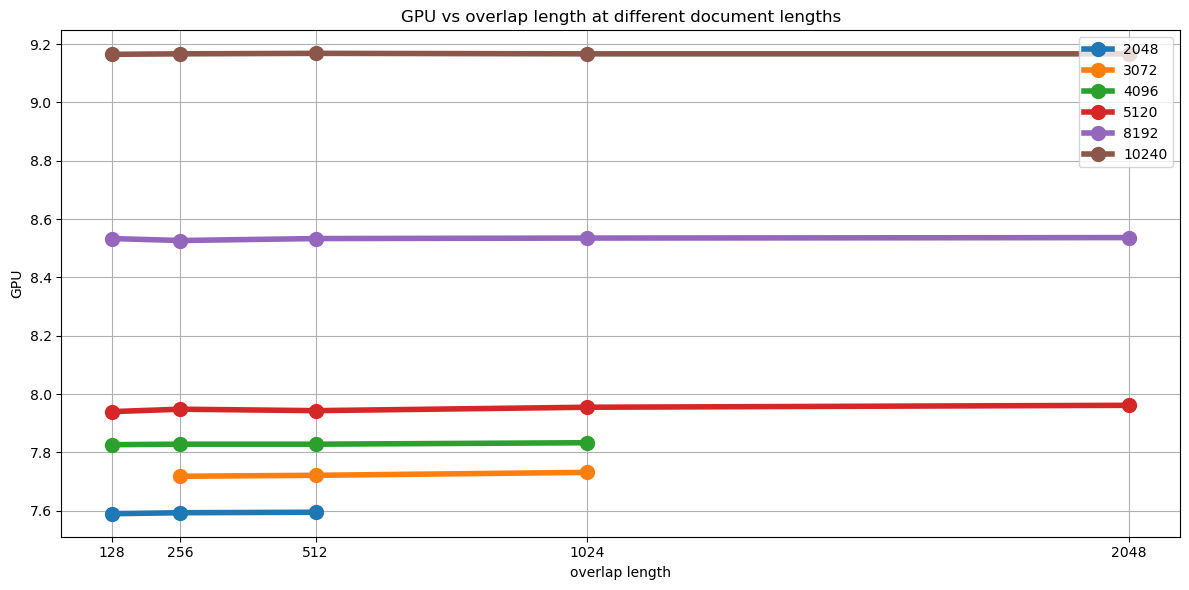

In [11]:
df_ = macro_fdf.reset_index()
df_ = df_[~df_["hierarchical"]]
plt.figure(figsize=(12, 6))
for document_len, df__ in df_.groupby("document_len"):
    df__ = df__.sort_values(by="overlap_len", ascending=True)
    overlap_lens = df__["overlap_len"].tolist()
    scores = df__[("max_gpu","mean")].tolist()
    plt.plot(overlap_lens, scores, label=str(document_len), lw=4, marker=".", markersize=20)
plt.xlabel("overlap length")
plt.ylabel("GPU")
plt.xticks(ticks=[128, 256, 512, 1024, 2048])
# plt.yticks(ticks=[25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
plt.title("GPU vs overlap length at different document lengths")
plt.legend()
plt.tight_layout()
plt.grid(visible=True, which="both")
plt.show()

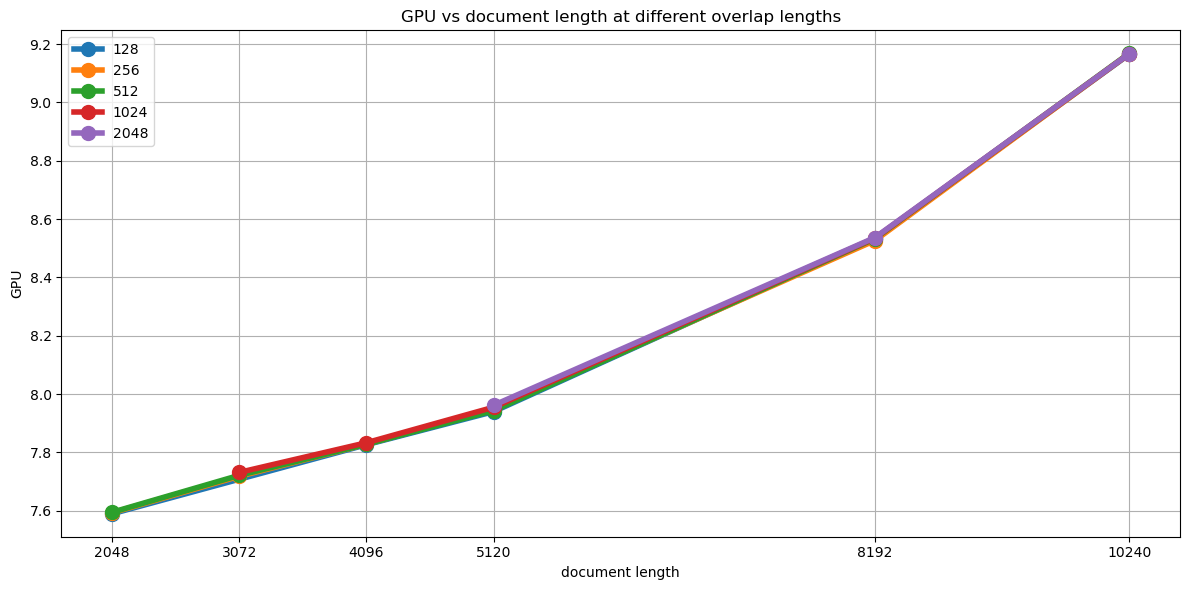

In [13]:
df_ = macro_fdf.reset_index()
df_ = df_[~df_["hierarchical"]]
plt.figure(figsize=(12, 6))
for overlap_len, df__ in df_.groupby("overlap_len"):
    df__ = df__.sort_values(by="document_len", ascending=True)
    document_lens = df__["document_len"].tolist()
    scores = df__[("max_gpu","mean")].tolist()
    plt.plot(document_lens, scores, label=str(overlap_len), lw=4, marker=".", markersize=20)
plt.xlabel("document length")
plt.ylabel("GPU")
plt.xticks(ticks=[2048, 3072, 4096, 5120, 8192, 10240])
# plt.yticks(ticks=[25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
plt.title("GPU vs document length at different overlap lengths")
plt.legend()
plt.tight_layout()
plt.grid(visible=True, which="both")
plt.show()

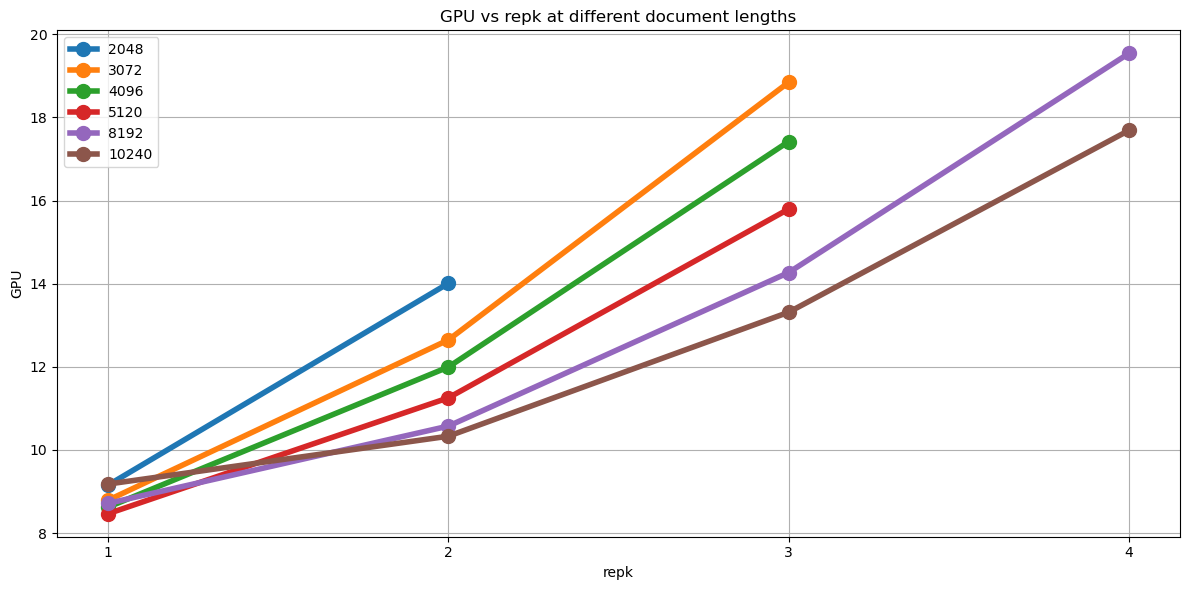

In [15]:
df_ = macro_fdf.reset_index()
df_ = df_[df_["hierarchical"]]
plt.figure(figsize=(12, 6))
for document_len, df__ in df_.groupby("document_len"):
    df__ = df__.sort_values(by="repk", ascending=True)
    repks = df__["repk"].tolist()
    scores = df__[("max_gpu","mean")].tolist()
    plt.plot(repks, scores, label=str(document_len), lw=4, marker=".", markersize=20)
plt.xlabel("repk")
plt.ylabel("GPU")
plt.xticks(ticks=[1, 2, 3, 4])
# plt.yticks(ticks=[25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
plt.title("GPU vs repk at different document lengths")
plt.legend()
plt.tight_layout()
plt.grid(visible=True, which="both")
plt.show()

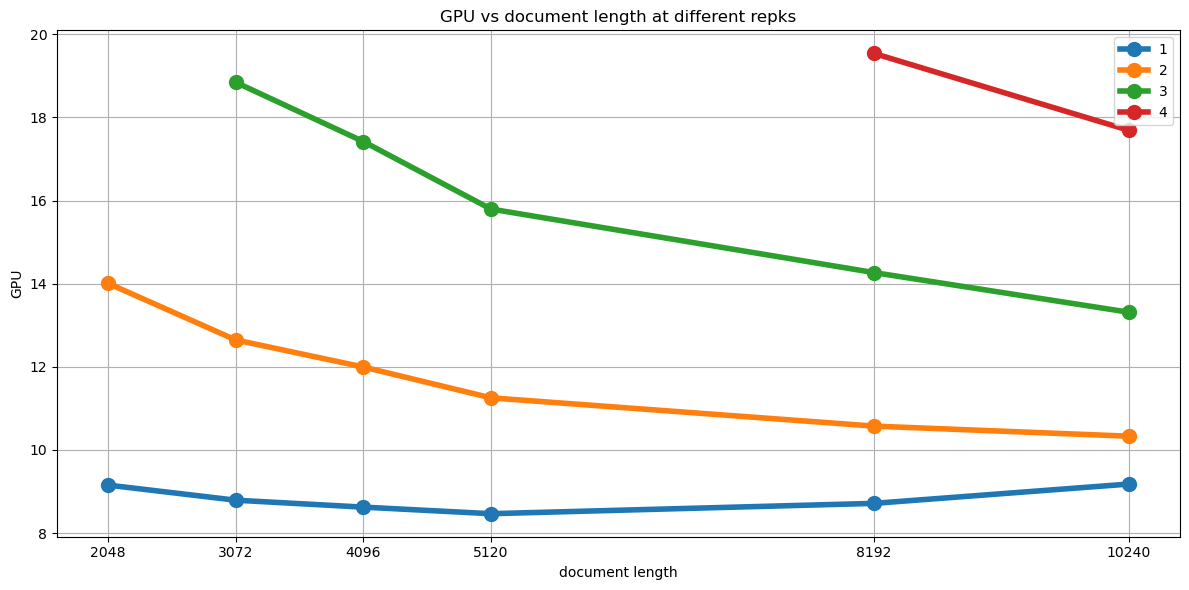

In [17]:
df_ = macro_fdf.reset_index()
df_ = df_[df_["hierarchical"]]
plt.figure(figsize=(12, 6))
for repk, df__ in df_.groupby("repk"):
    df__ = df__.sort_values(by="document_len", ascending=True)
    document_lens = df__["document_len"].tolist()
    scores = df__[("max_gpu","mean")].tolist()
    plt.plot(document_lens, scores, label=str(repk), lw=4, marker=".", markersize=20)
plt.xlabel("document length")
plt.ylabel("GPU")
plt.xticks(ticks=[2048, 3072, 4096, 5120, 8192, 10240])
# plt.yticks(ticks=[25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
plt.title("GPU vs document length at different repks")
plt.legend()
plt.tight_layout()
plt.grid(visible=True, which="both")
plt.show()

In [5]:
movie_to_document_length = collections.defaultdict()
with jsonlines.open(os.path.join(os.getenv("DATA_DIR"), 
                                 "mica_text_coref/movie_coref/results/regular/movie.jsonlines")) as reader:
    for obj in reader:
        movie_to_document_length[obj["movie"]] = len(obj["token"])
print(dict(movie_to_document_length))

{'avengers_endgame': 35816, 'dead_poets_society': 26200, 'john_wick': 24954, 'prestige': 35910, 'quiet_place': 27843, 'zootopia': 27127, 'shawshank': 8090, 'bourne': 8087, 'basterds': 7777}


In [6]:
fusion_memory_data = []
hierarchical_memory_data = []

for _, row in fdf.iterrows():
    n = movie_to_document_length[row["movie"]]
    m = row["document_len"]
    d = row["overlap_len"]
    r = row["repk"]
    gpu = row["max_gpu"]
    if row["hierarchical"]:
        hierarchical_memory_data.append([n, m, r, gpu])
    else:
        fusion_memory_data.append([n, m, d, gpu])

fusion_memory_df = pd.DataFrame(fusion_memory_data, columns=["n", "m", "d", "mem"])
hierarchical_memory_df = pd.DataFrame(hierarchical_memory_data, columns=["n", "m", "r", "mem"])

print(f"fusion_mem_df={fusion_memory_df.shape}, hierarchical_mem_df={hierarchical_memory_df.shape}")
print(f"fusion_mem_df: {fusion_memory_df.n.unique().size} movies, "
      f"{fusion_memory_df.m.unique().size} subdocument lengths, {fusion_memory_df.d.unique().size} overlap lengths")
print(f"hierarchical_mem_df: {hierarchical_memory_df.n.unique().size} movies, "
      f"{hierarchical_memory_df.m.unique().size} subdocument lengths, {hierarchical_memory_df.r.unique().size} repks")

fusion_mem_df=(155, 4), hierarchical_mem_df=(167, 4)
fusion_mem_df: 6 movies, 6 subdocument lengths, 5 overlap lengths
hierarchical_mem_df: 6 movies, 6 subdocument lengths, 5 repks


In [14]:
fusion_mem_model = smf.ols("mem ~ n*m*d", data=fusion_memory_df)
fusion_mem_fit = fusion_mem_model.fit()
print(fusion_mem_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    mem   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     635.1
Date:                Fri, 20 Jan 2023   Prob (F-statistic):          1.86e-106
Time:                        13:15:02   Log-Likelihood:                 136.68
No. Observations:                 155   AIC:                            -257.4
Df Residuals:                     147   BIC:                            -233.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.9259      0.188     36.767      0.0

In [15]:
hierarchical_mem_model = smf.ols("mem ~ n*m*r", data=hierarchical_memory_df)
hierarchical_mem_fit = hierarchical_mem_model.fit()
print(hierarchical_mem_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    mem   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     53.72
Date:                Fri, 20 Jan 2023   Prob (F-statistic):           9.58e-39
Time:                        13:15:41   Log-Likelihood:                -473.04
No. Observations:                 167   AIC:                             962.1
Df Residuals:                     159   BIC:                             987.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.2454     11.133     -0.381      0.7